In [ ]:
!pip install --user -q transformers accelerate bitsandbytes \
datasets evaluate sentence-transformers faiss-gpu langchain \
langchain-community openpyxl pacmap ragatouille langchain-huggingface rank_bm25 gdown

!pip install -U ipywidgets

In [ ]:
!nvidia-smi

In [ ]:
import os
os.environ["PATH"] += ":/root/.local/bin"

In [ ]:
!pip install -U langchain-community
# !pip install vllm

In [ ]:
# 降级transformer
# !pip install transformers==4.30.2
!pip install vllm

In [ ]:
# !pip install sentence-transformers==2.2.2

In [1]:
# Import standard Python tools
import os
import io
import pickle
import contextlib
from typing import Optional, List, Tuple
import json
import torch
# from rank_bm25 import BM25Okapi
from concurrent.futures import ThreadPoolExecutor

# Import libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# Configure pandas for better visualization of retriever outputs
pd.set_option("display.max_colwidth", None)

# Import text processing and embeddings tools
from sentence_transformers import SentenceTransformer
from transformers import (
    pipeline,
    Pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForQuestionAnswering,
    BitsAndBytesConfig,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
)

# Import LangChain tools
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
# from langchain_community.vectorstores.utils import DistanceStrategy

# Import RAG-specific tools
# from ragatouille import RAGPretrainedModel

# Import tools for datasets
from datasets import Dataset

# Advanced visualization and dimensionality reduction tools
import pacmap

# Progress bar for loops
from tqdm.notebook import tqdm

# Import vLLM
from vllm import LLM, SamplingParams

INFO 04-03 22:08:20 [__init__.py:239] Automatically detected platform cuda.


In [2]:
if not os.path.exists("/kaggle/working/triviaqa-rc"):
    # Download the dataset in the working space of Kaggle
    !wget https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
    # Create a directory for extracting the content
    !mkdir /kaggle/working/triviaqa-rc
    # Extract the content from the downloaded file
    !tar -xzf /kaggle/working/triviaqa-rc.tar.gz -C /kaggle/working/triviaqa-rc
    # Delete the compressed file
    !rm /kaggle/working/triviaqa-rc.tar.gz

--2025-04-03 22:08:25--  https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
Resolving nlp.cs.washington.edu (nlp.cs.washington.edu)... 128.208.3.117, 2607:4000:200:12:3eec:efff:fe5e:6f68
Connecting to nlp.cs.washington.edu (nlp.cs.washington.edu)|128.208.3.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2665779500 (2.5G) [application/x-gzip]
Saving to: ‘triviaqa-rc.tar.gz’

triviaqa-rc.tar.gz  100%[===================>]   2.48G  74.5MB/s    in 32s     

2025-04-03 22:08:57 (79.3 MB/s) - ‘triviaqa-rc.tar.gz’ saved [2665779500/2665779500]



In [3]:
# Load the original training file
train_data = pd.read_json("/kaggle/working/triviaqa-rc/qa/wikipedia-train.json")

# Split the data: first 7900 questions for validation, the rest for training
validation_data = train_data.iloc[:7900]
train_data = train_data.iloc[7900:] # We shouldn't use this (it's not necessary if we are using a RAG system)

# Load the original validation file to use as test data
test_data = pd.read_json("/kaggle/working/triviaqa-rc/qa/wikipedia-dev.json") # The actual test data is hidden

print("Data partitioned successfully:")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

Data partitioned successfully:
Training set size: 53988
Validation set size: 7900
Test set size: 7993


In [4]:
validation_data.head(3)

,Data,Domain,Split,VerifiedEval,Version
0,"{'Answer': {'Aliases': ['Park Grove (1895)', 'York UA', 'Yorkish', 'UN/LOCODE:GBYRK', 'York, UK', 'Eoforwic', 'Park Grove School', 'York Ham', 'The weather in York', 'City of York', 'York, England', 'York, Yorkshire', 'York ham', 'County Borough of York', 'YORK', 'Eoferwic', 'Park Grove Primary School', 'York, North Yorkshire', 'Yoisk', 'York', 'York (England)'], 'MatchedWikiEntityName': 'York', 'NormalizedAliases': ['york yorkshire', 'eoferwic', 'park grove primary school', 'park grove school', 'weather in york', 'park grove 1895', 'eoforwic', 'county borough of york', 'york uk', 'un locode gbyrk', 'city of york', 'york england', 'york ua', 'york ham', 'york', 'yorkish', 'yoisk', 'york north yorkshire'], 'NormalizedMatchedWikiEntityName': 'york', 'NormalizedValue': 'york', 'Type': 'WikipediaEntity', 'Value': 'York'}, 'EntityPages': [{'DocSource': 'TagMe', 'Filename': 'England.txt', 'Title': 'England'}, {'DocSource': 'TagMe', 'Filename': 'Judi_Dench.txt', 'Title': 'Judi Dench'}], 'Question': 'Where in England was Dame Judi Dench born?', 'QuestionId': 'tc_3', 'QuestionSource': 'http://www.triviacountry.com/'}",Wikipedia,train,False,1
1,"{'Answer': {'Aliases': ['Portogało', 'Republic of Portugal', 'PORTUGAL', 'Portekiz', 'Portugallu', 'O Papagaio', 'ISO 3166-1:PT', 'Portunga', 'Phu-to-ga', 'Potigal', 'Portûnga', 'Portugul', 'An Phortaingéil', 'Portugāle', 'Portugale', 'Portingale', 'Potiti', 'Portugali', 'Portugall', 'Portekîz', 'Bo Dao Nha', 'Portuguese Republic', 'Portogallo', 'Portugaul', 'Portogalo', 'Portyngal', 'Yn Phortiugal', 'Portugalio', 'Portugál', 'Portugual', 'Portuga', 'Portgual', 'Portugalsko', 'Portugaleje', 'Phû-tô-gâ', 'Portugalujo', 'Portugalija', 'Pertual', 'Pòtigal', 'Portugal', 'Bồ Đào Nha', 'Portugalska', 'República Portuguesa', 'Portiwgal', 'Portugalėjė', 'Portúgal', 'Portegal', 'An Phortaingeil', 'Republica Portuguesa'], 'MatchedWikiEntityName': 'Portugal', 'NormalizedAliases': ['portugul', 'portugallu', 'portugalska', 'pòtigal', 'portugaul', 'portugalujo', 'portuguese republic', 'iso 3166 1 pt', 'republic of portugal', 'portugalsko', 'portugual', 'bồ đào nha', 'portugall', 'portûnga', 'bo dao nha', 'phortaingeil', 'portugale', 'portugal', 'portugál', 'portugalėjė', 'portiwgal', 'phu to ga', 'portugalija', 'portugalio', 'portogallo', 'phû tô gâ', 'portegal', 'república portuguesa', 'portugāle', 'phortaingéil', 'yn phortiugal', 'portogało', 'portuga', 'portugaleje', 'portekiz', 'o papagaio', 'portunga', 'potigal', 'portekîz', 'pertual', 'portogalo', 'portugali', 'portyngal', 'republica portuguesa', 'portingale', 'portúgal', 'portgual', 'potiti'], 'NormalizedMatchedWikiEntityName': 'portugal', 'NormalizedValue': 'portugal', 'Type': 'WikipediaEntity', 'Value': 'Portugal'}, 'EntityPages': [{'DocSource': 'TagMe', 'Filename': 'Nation_state.txt', 'Title': 'Nation state'}, {'DocSource': 'TagMe', 'Filename': 'Angola.txt', 'Title': 'Angola'}, {'DocSource': 'Search', 'Filename': 'Angolan_Civil_War.txt', 'Title': 'Angolan Civil War', 'originalUrl': 'https://simple.wikipedia.org/wiki/Angolan_Civil_War'}], 'Question': 'From which country did Angola achieve independence in 1975?', 'QuestionId': 'tc_8', 'QuestionSource': 'http://www.triviacountry.com/'}",Wikipedia,train,False,1
2,"{'Answer': {'Aliases': ['Chi-Beria', 'Sayre language academy', 'Chicago', 'Chicago, Illinois', 'Hog Butcher for the World', 'Land of smelly onions', 'Ariel Community Academy', 'The weather in Chicago', 'Chicago, Illinois, U.S.A.', 'Chicago, Illionis', 'Near North Montessori', 'Religion in Chicago', 'Chicago Finance Committee', 'The Paris of America', 'The city of Chicago', 'City of Chicago', 'List of sister cities of Chicago', 'UN/LOCODE:USCHI', 'Chicago theatre scene', 'Chicago, WI', 'The City of Broad Shoulders', 'City of Broad Shoulders', 'Sister Cities of Chicago', 'Chicago il', 'Chicago, Illinois, USA', 'Performing arts in Chicago', 'Chicago Transportation Committee', 'Chicago, Wisconsin', 'City 

In [5]:
#Build a list of docs from the downloaded Wikipedia documents
def getDocs(examples):
    # List of docs
    docs = []
    # Extracting metadata and filenames from the examples (training data)
    for example in examples["Data"]:
        filename = example["EntityPages"][0]["Filename"]
        with open(f"triviaqa-rc/evidence/wikipedia/{filename}", "r") as file:
            context_text = file.read()
        # Create a Document for RAG
        newDoc = LangchainDocument(
                metadata={
                    'question_id': example['QuestionId'],
                    'source': example['EntityPages'][0]['DocSource'],
                    'answer_type': example['Answer']['Type'],
                    'entity_name': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'aliases': example['Answer'].get('Aliases', []), # Default to empty list if missing
                    'normalized_value': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'filename': example['EntityPages'][0]['Filename'],
                },
                page_content=context_text
        )
        docs.append(newDoc)
    return docs

In [6]:
# Use the validation data to decide the size of each document chunk
RAW_KNOWLEDGE_BASE = getDocs(validation_data)

# Use the test data to create the knowledge base
#RAW_KNOWLEDGE_BASE = getDocs(test_data)

In [7]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
# 在这里选择chunk大小
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100, # The number of characters to overlap between chunks
    add_start_index=True, # If `True`, includes chunk's start index in metadata
    strip_whitespace=True, # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE: # We are using the validation data to test
    docs_processed += text_splitter.split_documents([doc])

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/336466 [00:00<?, ?it/s]

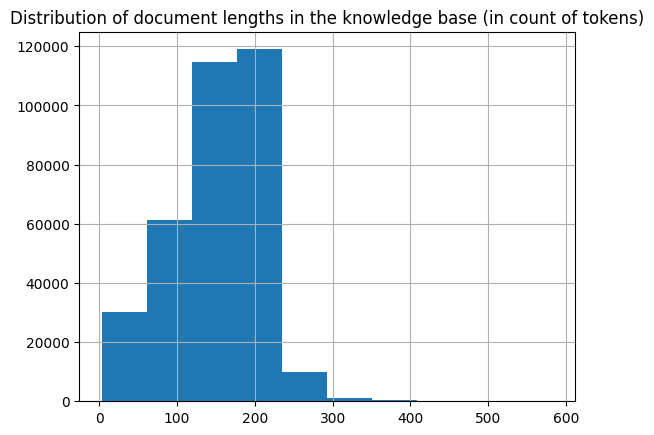

In [8]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/75896 [00:00<?, ?it/s]

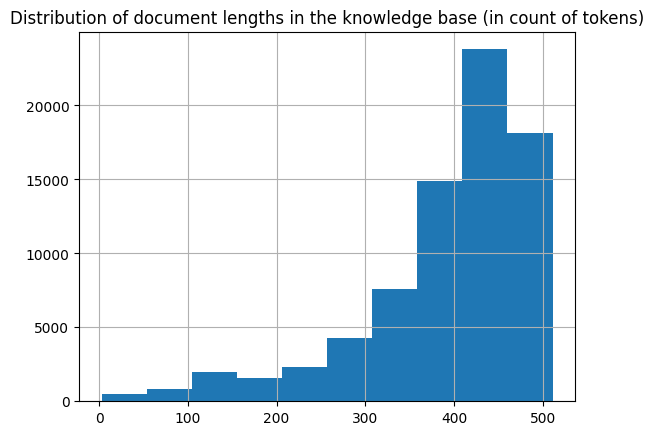

In [9]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small" # The name of the SentenceTransformer

# Function to split the documents into chunks
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """

    MARKDOWN_SEPARATORS = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

# Processing the RAW_KNOWLEDGE_BASE (validation_data)
docs_processed = split_documents(
    512, # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Save the object
with open("/kaggle/working/docs_processed.pkl", "wb") as file:
    pickle.dump(docs_processed, file)

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
# The name of the embedding model
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
# HuggingFace Embedding Model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [ ]:
# This cell below takes around half an hour to run
# 不用跑
# # Create the vector database of document embeddings
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

# #Save the vector database in a file
faiss_index_path = "/kaggle/working/knowledge_vector_database-validation"


In [18]:
# Load the pre-created vector database
faiss_index_path = "/kaggle/input/dataset/knowledge_vector_database-validation"
# faiss_index_path = "/kaggle/working/knowledge-vector-database-validation"
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(faiss_index_path, embedding_model, allow_dangerous_deserialization=True)

In [17]:
# KNOWLEDGE_VECTOR_DATABASE.save_local(faiss_index_path)
# 这个好像也不用跑

RuntimeError: Error in faiss::FileIOWriter::FileIOWriter(const char*) at /project/faiss/faiss/impl/io.cpp:101: Error: 'f' failed: could not open /kaggle/input/dataset/knowledge_vector_database-validation/index.faiss for writing: Read-only file system

In [19]:
# # Embed a user query in the same space
user_query = "Which Mediterranean island was once known as Alashiya?"
query_vector = embedding_model.embed_query(user_query)

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

RuntimeError: Error in virtual void faiss::IndexFlatCodes::reconstruct_n(faiss::idx_t, faiss::idx_t, float*) const at /project/faiss/faiss/IndexFlatCodes.cpp:76: Error: 'ni == 0 || (i0 >= 0 && i0 + ni <= ntotal)' failed

In [21]:
pio.renderers.default = 'iframe'

In [ ]:
# Create DataFrame for document embeddings
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],  # Accessing document projection
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))  # Only iterate over document embeddings
    ]
    + [
        {
            "x": documents_projected[-1, 0],  # Append the query vector
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    text="extract",
    symbol="symbol",
    size="size_col",
    title="2D Projection of Documents and Query",
    width=1000,
    height=700,
)
fig.show()

In [22]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top 1 document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)
print(
    "\n==================================Top 2 document=================================="
)
print(retrieved_docs[1].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[1].metadata)


Starting retrieval for user_query='Which Mediterranean island was once known as Alashiya?'...


Chunks:   0%|          | 0/1 [00:00<?, ?it/s]


==================================Top 1 document==================================
The Balearic Islands (; ;    ) are an archipelago of Spain in the western Mediterranean Sea, near the eastern coast of the Iberian Peninsula.

The four largest islands are Majorca, Minorca, Ibiza and Formentera. There are many minor islands and islets close to the larger islands, including Cabrera, Dragonera and S'Espalmador. The islands have a Mediterranean climate, and the four major islands are all popular tourist destinations. Ibiza in particular is known as an international party destination, attracting many of the world's most popular DJs to its nightclubs.  The islands' culture and cuisine are similar to that of the rest of Spain.

The archipelago forms an autonomous community and a province of Spain, with Palma de Mallorca as the capital. The 2007 Statute of Autonomy declares the Balearic Islands as one nationality of Spain.  The co-official languages in the Balearic Islands are Catalan and Span

In [23]:
from rank_bm25 import BM25Okapi

In [24]:
# Extract the page content from the documents
doc_texts = [doc.page_content for doc in docs_processed]

# Tokenize the document texts
tokenized_corpus = [text.split() for text in doc_texts]

# Initialize BM25 retriever
bm25 = BM25Okapi(tokenized_corpus)

# File path for saving the BM25 retriever
bm25_file_path = '/kaggle/working/bm25_retriever_validation.pkl'

# Save the tokenized corpus
with open(bm25_file_path, 'wb') as f:
    pickle.dump(tokenized_corpus, f)

In [25]:
# Instead
# Load the object
with open("/kaggle/input/docs-processed-validation/docs_processed.pkl", "rb") as file:
    docs_processed = pickle.load(file)

# Load the tokenized corpus
with open('/kaggle/input/bm25-retriever-validation/bm25_retriever_validation.pkl', 'rb') as f:
    loaded_tokenized_corpus = pickle.load(f)

# Reinitialize BM25 retriever using the loaded corpus
bm25 = BM25Okapi(loaded_tokenized_corpus)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/docs-processed-validation/docs_processed.pkl'

In [26]:
def bm25_retrieve(query, k=5):
    """
    Perform retrieval using BM25 on LangChain documents.

    Args:
        query (str): The search query.
        k (int): The number of top documents to retrieve.

    Returns:
        list: A list of tuples with document indices, scores, and the documents themselves.
    """
    # Tokenize the query
    tokenized_query = query.split()

    # Get scores for all documents
    scores = bm25.get_scores(tokenized_query)

    # Get top-k document indices and scores
    top_k_indices = np.argsort(scores)[::-1][:k]
    top_k_results = [(index, scores[index], docs_processed[index]) for index in top_k_indices]

    return top_k_results

In [27]:
# Example query
query = "Which Lloyd Webber musical premiered in the US on 10th December 1993?"
top_docs = bm25_retrieve(query, k=3)

# Display results
for idx, score, doc in top_docs:
    print("================================================================================================")
    print(f"Doc Index: {idx}, Score: {score}, Content: {doc.page_content}, Metadata: {doc.metadata}")

Doc Index: 13529, Score: 48.64659654613357, Content: Starlight Express (1984) was a commercial hit, but received negative reviews from the critics. It enjoyed a record run in the West End, but ran for less than two years on Broadway. The show has also seen two tours of the US, as well as an Australian/Japanese production, a three-year UK touring production, which transferred to New Zealand later in 2009. The show also runs full-time in a custom-built theatre in Bochum, Germany, where it has been running since 1988.

Lloyd Webber wrote a Requiem Mass dedicated to his father, William, who had died in 1982. It premiered at St. Thomas Church in New York on 24 February 1985. Church music had been a part of the composer's upbringing and the composition was inspired by an article he had read about the plight of Cambodian orphans. Lloyd Webber had on a number of occasions written sacred music for the annual Sydmonton Festival.  Lloyd Webber received a Grammy Award in 1986 for Requiem in the ca

In [28]:
!pip install together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.


In [29]:
from together import Together
import tiktoken
import numpy as np
from typing import List

# 初始化 Together API 客户端
client = Together(api_key="4527c2996c934ec963a8290da43a7329860a63384b96aa4de523011457d83193")

# 获取 Llama-3.1-8B-Instruct-Turbo 的 tokenizer
enc = tiktoken.get_encoding("cl100k_base")

# Sampling 参数类
class SamplingParams:
    def __init__(self, n=1, top_p=0.9, temperature=0.7, repetition_penalty=1.2, max_tokens=256):
        self.n = n
        self.top_p = top_p
        self.temperature = temperature
        self.repetition_penalty = repetition_penalty
        self.max_tokens = max_tokens

# 自定义 Tokenizer 代理类
class TogetherTokenizer:
    """ 模拟 transformers.Tokenizer，提供 `apply_chat_template` 和 `tokenize` 以兼容原代码 """

    def __init__(self):
        pass

    def apply_chat_template(self, messages, tokenize=False, add_generation_prompt=True):
        """ 模拟 `apply_chat_template`，将聊天格式转换为文本 """
        chat_template = ""
        for msg in messages:
            role = msg.get("role", "user")
            content = msg.get("content", "")
            chat_template += f"{role.capitalize()}: {content}\n"

        if add_generation_prompt:
            chat_template += "Assistant: "  # 让 LLM 继续生成回答
        
        return chat_template if not tokenize else chat_template.split()

    def tokenize(self, text):
        """ 使用 `tiktoken` 进行 tokenization """
        return enc.encode(text)

# Together LLM Reader
class TogetherLLMReader:
    def __init__(self, model_name="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo", api_key="4527c2996c934ec963a8290da43a7329860a63384b96aa4de523011457d83193"):
        self.client = Together(api_key=api_key)
        self.model_name = model_name
        self.tokenizer = TogetherTokenizer()

    def get_tokenizer(self):
        """ 兼容原代码，返回自定义 tokenizer """
        return self.tokenizer

    def generate(self, prompts: List[str], sampling_params: SamplingParams):
        """ 兼容原代码，支持批量 Prompt 生成 """
        responses = []
        for prompt in prompts:
            response = self.client.chat.completions.create(
                model=self.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=sampling_params.temperature,
                max_tokens=sampling_params.max_tokens,
                top_p=sampling_params.top_p,
                repetition_penalty=sampling_params.repetition_penalty,
                n=sampling_params.n,
            )
            responses.append(response.choices[0].message.content)

        # 兼容原代码：包装返回结果
        return [LLMOutput(prompt, generated_text) for prompt, generated_text in zip(prompts, responses)]

# 兼容原代码的输出格式
class LLMOutput:
    def __init__(self, prompt, text):
        self.prompt = prompt
        self.outputs = [LLMResponse(text)]

class LLMResponse:
    def __init__(self, text):
        self.text = text


In [ ]:

# Define the model
# from together import Together
'''
READER_MODEL_NAME = "/kaggle/input/zephyr-7b-beta-awq"
#READER_MODEL_NAME = "/kaggle/input/hugging-quants-meta-llama-3-1-8b-instruct-awq-int4"
#READER_MODEL_NAME = "PyrTools/Ministral-8B-Instruct-2410-AWQ"

# Configure the model

model = LLM( 
    model = READER_MODEL_NAME,
    quantization="awq",
    tensor_parallel_size=2, 
    gpu_memory_utilization=0.95, 
    trust_remote_code=True,
    dtype="half", 
    enforce_eager=True,
    #max_model_len=1024,
    disable_log_stats=True
)

tokenizer = model.get_tokenizer()
'''

In [33]:
# 初始化模型
model = TogetherLLMReader(api_key="4527c2996c934ec963a8290da43a7329860a63384b96aa4de523011457d83193")

# 获取 tokenizer
tokenizer = model.get_tokenizer()

In [34]:
# Initialize a variable to accumulate the average token counts
acmul = 0

for instance in validation_data.Data.iloc:
  # Check for the existence of the Value field and other fields; default to an empty list if missing
  value = instance['Answer'].get('Value', '') # Use an empty string if 'Value' is missing
  normalized_value = instance['Answer'].get('NormalizedValue', '') # Use an empty string if 'NormalizedValue' is missing
  aliases = instance['Answer'].get('Aliases', []) # Use an empty list if 'Aliases' is missing
  normalized_aliases = instance['Answer'].get('NormalizedAliases', []) # Use an empty list if 'NormalizedAliases' is missing

  # Combine all available fields into one list of strings
  all_text = [value, normalized_value] + aliases + normalized_aliases
  # Tokenize each text and calculate token counts
  token_counts = [len(tokenizer.tokenize(text)) for text in all_text]
  # Compute average token count
  average_tokens = np.mean(token_counts)
  # Add the average token count to the accumulator
  acmul += average_tokens

# Calculate the overall average token count across all instances in the dataset
final_average_tokens = acmul / len(validation_data)

print(f"The average number of tokens for an answer is: {final_average_tokens:.2f}")


The average number of tokens for an answer is: 3.95


In [35]:
# Define the sampling parameters
sampling_params = SamplingParams(
    n = 1,
    top_p=0.9,
    temperature=0,
    repetition_penalty=1.2,
    max_tokens=5,     # Maximum number of tokens
)

In [36]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).
Do NOT generate sentences, explanations, or additional context.
Stop immediately after providing the answer. Do not generate any further words or tokens.
If the context does not provide any useful information, answer the question based on your own knowledge.
I am going to provide you five examples:

Question: What is the capital of Kenya?
Answer: Nairobi
---
Question: What was the name of the pig leader in George Orwell's Animal Farm?
Answer: Napoleon
---
Question: Which artist created the Katzenjammer Kids?
Answer: Rudolph Dirks
---
Question: Who was Geena Davis's husband when they made the loss-maker Cutthroat Island?
Answer: Renny Harlin
---
Question: Who was married to Spandau Ballet's Gary Kemp and later to Jude Law?
Answer: Sadie Frost

"""
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}"""
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

System: Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).
Do NOT generate sentences, explanations, or additional context.
Stop immediately after providing the answer. Do not generate any further words or tokens.
If the context does not provide any useful information, answer the question based on your own knowledge.
I am going to provide you five examples:

Question: What is the capital of Kenya?
Answer: Nairobi
---
Question: What was the name of the pig leader in George Orwell's Animal Farm?
Answer: Napoleon
---
Question: Which artist created the Katzenjammer Kids?
Answer: Rudolph Dirks
---
Question: Who was Geena Davis's husband when they made the loss-maker Cutthroat Island?
Answer: Renny Harlin
---
Question: Who was married to Spandau Ballet's Gary Kemp and later to Jude Law?
Answer: Sadie Frost


User: Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
Assistant: 


In [37]:
question = "Which Lloyd Webber musical premiered in the US on 10th December 1993?"
context = ""


prompt = [RAG_PROMPT_TEMPLATE.format(question = question, context = context)]
outputs = model.generate(prompt, sampling_params)

for output in outputs:
    generated_text = output.outputs[0].text
    prompt = output.prompt
    print(f"Question: {question!r}")
    print(f"Prompt: {prompt!r}")
    print(f"Generated text: {generated_text!r}")

Question: 'Which Lloyd Webber musical premiered in the US on 10th December 1993?'
Prompt: "System: Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).\nDo NOT generate sentences, explanations, or additional context.\nStop immediately after providing the answer. Do not generate any further words or tokens.\nIf the context does not provide any useful information, answer the question based on your own knowledge.\nI am going to provide you five examples:\n\nQuestion: What is the capital of Kenya?\nAnswer: Nairobi\n---\nQuestion: What was the name of the pig leader in George Orwell's Animal Farm?\nAnswer: Napoleon\n---\nQuestion: Which artist created the Katzenjammer Kids?\nAnswer: Rudolph Dirks\n---\nQuestion: Who was Geena Davis's husband when they made the loss-maker Cutthroat Island?\nAnswer: Renny Harlin\n---\nQuestion: Who was married to Spandau Ballet's Gary Kemp and later to Jude Law?\nAnswer: Sadie Frost\n\n\nUser: Cont

In [38]:
#Context provided by the embedding model

question = "Which Lloyd Webber musical premiered in the US on 10th December 1993?"

relevant_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(question, k=3)
relevant_docs = [doc.page_content for doc in relevant_docs]
context = "\nExtracted documents:\n"
context += "".join(
            [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
        )

prompt = [RAG_PROMPT_TEMPLATE.format(question = question, context = context)]
outputs = model.generate(prompt, sampling_params)

for output in outputs:
    generated_text = output.outputs[0].text
    prompt = output.prompt
    print(f"Question: {question!r}")
    print(f"Prompt: {prompt!r}")
    print(f"Generated text: {generated_text!r}")

Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Question: 'Which Lloyd Webber musical premiered in the US on 10th December 1993?'
Prompt: 'System: Answer the question with only one word or the simplest possible response (e.g., a single number or a single word).\nDo NOT generate sentences, explanations, or additional context.\nStop immediately after providing the answer. Do not generate any further words or tokens.\nIf the context does not provide any useful information, answer the question based on your own knowledge.\nI am going to provide you five examples:\n\nQuestion: What is the capital of Kenya?\nAnswer: Nairobi\n---\nQuestion: What was the name of the pig leader in George Orwell\'s Animal Farm?\nAnswer: Napoleon\n---\nQuestion: Which artist created the Katzenjammer Kids?\nAnswer: Rudolph Dirks\n---\nQuestion: Who was Geena Davis\'s husband when they made the loss-maker Cutthroat Island?\nAnswer: Renny Harlin\n---\nQuestion: Who was married to Spandau Ballet\'s Gary Kemp and later to Jude Law?\nAnswer: Sadie Frost\n\n\nUser: C

In [40]:
# from ragatouille import RAGPretrainedModel

ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [41]:
def silent_rerank(reranker, question, relevant_docs, k):
    # Create a temporary buffer to capture stdout and stderr
    with io.StringIO() as buf, contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        # Call the rerank function
        ranked_docs = reranker.rerank(question, relevant_docs, k=k)
    return ranked_docs

def retrieve(
    question: str,
    embedding: Optional[List[float]] = None,
    knowledge_index=None,
    reranker = None,
    # reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 3,
    printing: bool = True,
    retriever: str = "faiss"
) -> Tuple[str, List[str]]:
    """
    Retrieves and optionally reranks documents from the knowledge index.
    """
    if retriever not in {"faiss", "bm25", None}:
        raise ValueError(f"Unsupported retriever: {retriever}")

    # Step 1: Retrieve initial documents if a retriever is used
    if retriever == "faiss" or retriever == "bm25":
        if printing:
            print("=> Retrieving documents...")

        relevant_docs = []

        if retriever == "faiss":
            if embedding is None or knowledge_index is None:
                raise ValueError("For 'faiss' retriever, 'embedding' and 'knowledge_index' must be provided.")
            # Perform search using the precomputed embedding
            relevant_docs = knowledge_index.similarity_search_by_vector(embedding, k=num_retrieved_docs)
            relevant_docs = [doc.page_content for doc in relevant_docs]  # Extract only the content
        elif retriever == "bm25":
            # Retrieve documents using BM25
            retrieved_docs = bm25_retrieve(question, k=num_retrieved_docs)
            relevant_docs = [doc.page_content for _, _, doc in retrieved_docs]

        # Step 2: Optionally rerank the retrieved documents
        if reranker:
            if printing:
                print("=> Reranking documents...")
            relevant_docs = silent_rerank(reranker, question, relevant_docs, k=num_docs_final)
            relevant_docs = [doc["content"] for doc in relevant_docs]

        # Limit the number of final documents to the desired count
        relevant_docs = relevant_docs[:num_docs_final]

        # Step 3: Build the context for the LLM model
        context = "\nExtracted documents:\n" + "".join(
            [f"Document {i}:::\n{doc}\n" for i, doc in enumerate(relevant_docs)]
        )
    else:
        # If no retriever is provided, set the context as empty
        context = ""
        relevant_docs = [""]

    return context, relevant_docs

def read(llm, sampling_params, prompt_template, contexts, questions):
    """
    Generates answers from the LLM by formatting the question-context pairs into prompts.
    """
    # Format prompts by combining questions and contexts
    prompts = [prompt_template.format(question=q, context=c) for q, c in zip(questions, contexts)]
    
    # Generate answers using the LLM
    outputs = llm.generate(prompts, sampling_params)
    
    # Extract the generated text from the outputs
    outputs = [output.outputs[0].text for output in outputs]
    
    return outputs

In [43]:
# Main function to answer questions using RAG
def answer_with_rag(
    questions: List[str],
    llm,
    prompt_template,
    sampling_params: dict,
    knowledge_index=None,
    embedding_model=None,
    reranker = None,
    # reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 3,
    printing: bool = True,
    retriever: str = "faiss"
) -> List[str]:
    """
    Main function for answering questions using a Retrieval-Augmented Generation (RAG) pipeline.
    """
    # Ensure that questions are in list format
    if isinstance(questions, str):
        questions = [questions]

    # Step 1: Generate embeddings for all questions in one go if using 'faiss'
    if retriever == "faiss":
        if embedding_model is None or knowledge_index is None:
            raise ValueError("For 'faiss' retriever, 'embedding_model' and 'knowledge_index' must be provided.")
        
        # Calculate all embeddings for the questions at once
        embeddings = embedding_model.embed_documents(questions)

    # Step 2: Retrieve contexts for each question
    contexts = []
    relevant_docs_list = []
    
    for idx, question in enumerate(questions):
        # Use the precomputed embedding for each question if using 'faiss'
        embedding = embeddings[idx] if retriever == "faiss" else None
        context, relevant_docs = retrieve(
            question,
            embedding=embedding,
            knowledge_index=knowledge_index if retriever == "faiss" else None,
            reranker=reranker,
            num_retrieved_docs=num_retrieved_docs,
            num_docs_final=num_docs_final,
            printing=printing,
            retriever=retriever,
        )
        contexts.append(context)
        relevant_docs_list.append(relevant_docs)

    # Step 3: Generate answers using the LLM model
    if printing:
        print("=> Generating answers...")
    answers = read(llm, sampling_params, prompt_template, contexts, questions)

    return answers, relevant_docs_list

In [45]:
validation_data_batch = validation_data[0:10] 
questions = [instance["Question"] for instance in validation_data_batch["Data"]]

answers, _ = answer_with_rag(
    questions= questions,
    llm = model,
    prompt_template = RAG_PROMPT_TEMPLATE,
    sampling_params = sampling_params,
    knowledge_index= None,
    embedding_model= None,
    reranker = None,
    # reranker = RERANKER,
    num_retrieved_docs = 30,
    num_docs_final = 3,
    printing = True,
    retriever = "bm25"
)

=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Retrieving documents...
=> Generating answers...


In [46]:
for q,a in zip(questions, answers):
    print("Question: ", q)
    print("Answer: ", a)

Question:  Where in England was Dame Judi Dench born?
Answer:  Heworth
Question:  From which country did Angola achieve independence in 1975?
Answer:  Portugal
Question:  Which city does David Soul come from?
Answer:  Chicago
Question:  Who won Super Bowl XX?
Answer:  Chicago Bears
Question:  Which was the first European country to abolish capital punishment?
Answer:  France
Question:  In which country did he widespread use of ISDN begin in 1988?
Answer:  None
Question:  What is Bruce Willis' real first name?
Answer:  Walter
Question:  Which William wrote the novel Lord Of The Flies?
Answer:  Golding
Question:  How is Joan Molinsky better known?
Answer:  Joan Rivers
Question:  In which branch of the arts is Patricia Neary famous?
Answer:  Ballet


In [49]:
question = "Where was born the Queen Elizabeth II?"

answers, relevant_docs_list = answer_with_rag(
    questions= question,
    llm = model,
    prompt_template = RAG_PROMPT_TEMPLATE,
    sampling_params = sampling_params,
    knowledge_index= KNOWLEDGE_VECTOR_DATABASE, 
    embedding_model= embedding_model,
    reranker = None, # If you don't want to use the reranker, set reranker = None
    num_retrieved_docs = 30,
    num_docs_final = 3,
    printing = True,
    retriever = "bm25" # Retriever options: "bm25", "faiss", None
)

print("Question: ", question)
print("Answer: ", answers[0])
print("Relevant Docs: ", relevant_docs_list[0])

=> Retrieving documents...
=> Generating answers...
Question:  Where was born the Queen Elizabeth II?
Answer:  London
Relevant Docs:  ["Prince Philip, Duke of Edinburgh (Philip Mountbatten; born Prince Philip of Greece and Denmark  on 10 June 1921) is the husband of Queen Elizabeth II. He is the longest-serving consort of a reigning British monarch and the oldest-ever male member of the British royal family.\n\nA member of the House of Schleswig-Holstein-Sonderburg-Glücksburg, Philip was born into the Greek and Danish royal families.  He was born in Greece but his family was exiled from the country when he was still an infant.  After being educated in France, Germany, and the United Kingdom, he joined the Royal Navy in 1939, at the age of 18.  From July 1939, he began corresponding with the 13-year-old Princess Elizabeth (his third cousin through Queen Victoria and second cousin once removed through Christian IX of Denmark), whom he had first met in 1934. During World War II he served 